In [1]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt
from diffusers import StableDiffusionPipeline
import os

from torch.utils.tensorboard.summary import image

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)



cuda


In [2]:
#Load the PipeLine
model_id = "/data_disk/dyy/stable-diffusion-2"
pipe = StableDiffusionPipeline.from_pretrained(model_id, revision="fp16", torch_dtype=torch.float16).to(device)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/data_disk/dyy/miniconda3/envs/Wzz/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/999 [00:00<?, ?it/s]

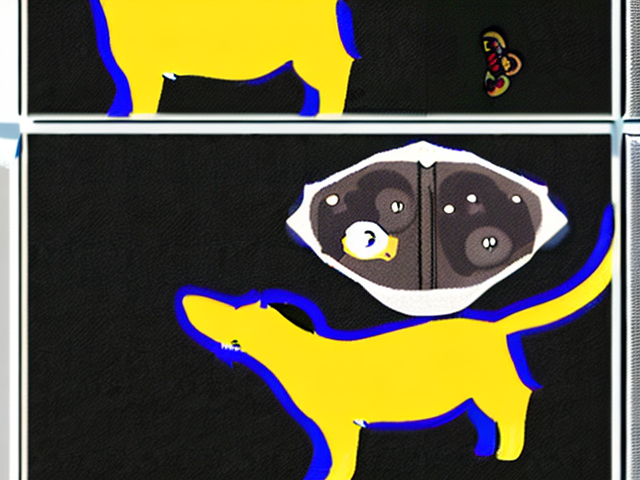

In [3]:
#Set up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(60)
#Run the pipeline,showing some of the available arguments
pipe_output = pipe(
    prompt='ghibli style yellow dog',
    #negative_prompt='Oversaturated,blurry,low quality',
    height=480, width=640,
    guidance_scale=8,  #这里默认是7.5
    num_inference_steps=999,
    generator=generator
)

#View the resulting image:
pipe_output.images[0]

In [ ]:
#image with different guidance_scale
cfg_scales = [1.1, 8, 10]
prompt = 'a dead man'
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(15, 15))
for i, ax in enumerate(axs):
    im = pipe(
        prompt,
        height=480, width=480,
        guidance_scale=cfg_scales[i],
        num_inference_steps=200,
        generator=torch.Generator(device=device).manual_seed(88)).images[0]

    ax.imshow(im)
    ax.set_title(f'cfg={cfg_scales[i]}')



# PipeLine Components

In [ ]:
print(list(pipe.components))

# VAE

In [ ]:
#将原图片压缩,经过VAE进入到隐空间, 再从隐空间解码成图片  这就是VAE的过程
images = torch.rand(1, 3, 512, 512).to(device) * 2 - 1  #可以映射到[-1,1]
images = images.to(torch.float16)
print(images.shape)

In [8]:
with torch.no_grad():
    latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean  #latent_distribution
    #0.18215是训练diffusion时用到的Normalization的缩放系数scaling factor,将[-1,1]->(-1,1)

In [9]:
#查看Pipe的组件,,或者pipe组件的组件
#pipe.vae

In [ ]:
#Decode again
with torch.no_grad():
    decode_images = pipe.vae.decode(latents / 0.18215).sample
print('Decoded images shape:', decode_images.shape)

# The Tokenizer(分词器) and Text Encoder
一个input_prompt会被分词器分词,然后输入到text encoder,得到一个text embedding(1,77,1024)  77表示最大长度<br>
它的作用就是将文本转化为向量,输入到UNet中,作为约束条件<br>
Tokenizer将文本转换为一个个词的id,token

In [ ]:
#Tikenize
input_ids = pipe.tokenizer(['A painting of a dog'])['input_ids']

print('Input ID -> decode token')
for input_id in input_ids[0]:
    print(f'{input_id} -> {pipe.tokenizer.decode(input_id)}')

In [ ]:
# Feed through CLIP text encoder
input_ids = torch.tensor(input_ids).to(device)
print(pipe.text_encoder(input_ids)['last_hidden_state'].shape)
print(pipe.text_encoder(input_ids)['pooler_output'].shape)  # 池化后的 [1, 1024]

with torch.no_grad():
    text_embeddings = pipe.text_encoder(input_ids)['last_hidden_state']
print('test embeddings shape:', text_embeddings.shape)

# Get the final text embeddings using the pipeline's _encode_prompt function
# 自行生成 prompt_embeds
prompt_embeds = pipe.text_encoder(input_ids)['last_hidden_state']
text_embeddings = pipe.encode_prompt(
    prompt=None,  # 因为我们已经提供了 prompt_embeds
    device=device,
    num_images_per_prompt=1,
    do_classifier_free_guidance=False,
    prompt_embeds=prompt_embeds,  # 使用手动生成的 prompt_embeds
)[0]


print(text_embeddings.shape)
#这里输出[1, 77, 1024],表示即便当前不够77的长度,也会填充0


## UNet

In [13]:
# dummy inputs:
timestep=pipe.scheduler.timesteps[0]
latents=torch.randn(1,4,64,64).to(device).half()
text_embeddings=torch.randn(1,77,1024).to(device).half()


In [ ]:
# model prediction
with torch.no_grad():
    unet_output = pipe.unet(latents, timestep, text_embeddings).sample
print('UNet output shape:', unet_output.shape)

# Scheduler

In [ ]:
#画出alphas(这里给出的是cumulative production,πalpha[i]表示保有原图的多少)
#画出betas(表示noise的强度)
plt.plot(pipe.scheduler.alphas_cumprod,label=r'$\bar{\alpha}$')
plt.xlabel('Timestep (from high noise to low noise')
plt.title('Noise schedule')
plt.show()
# 从图像可以看出,从高噪声到低噪声,alpha的值逐渐减小,表示保留原始图像的程度小,也就是越来越趋于全噪声

In [ ]:
# swapping scheduler
from diffusers import LMSDiscreteScheduler

# Replace the scheduler
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

# Print the config
print('Scheduler config:', pipe.scheduler)

# Generate an image with this new scheduler
pipe(prompt="Palette knife painting of an winter cityscape", height=480, width=480,
     generator=torch.Generator(device=device).manual_seed(42)).images[0]

## DIY Text2Image Sampling Function